In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve

from keras.preprocessing.sequence import pad_sequences

from imblearn.over_sampling import SMOTE

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 

%config InlineBackend.figure_format='retina'
%matplotlib inline

sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Read the datasets

In [ ]:
test_df=pd.read_excel('../input/coronavirus-tweets/Corona_NLP_test.xlsx')
train_df=pd.read_excel('../input/coronavirus-tweets/Corona_NLP_train.xlsx')

In [ ]:
print(f'Shape of the train dataset: {train_df.shape}')
print(f'Shape of the test dataset: {test_df.shape}')

Shape of the train dataset: (41157, 6)
Shape of the test dataset: (3798, 6)


In [ ]:
# Unique classes in target variable (Sentiment)
train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2020-02-03 00:00:00,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2020-02-03 00:00:00,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2020-02-03 00:00:00,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2020-02-03 00:00:00,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",2020-03-03 00:00:00,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Both train_df & test_df contains html tags,special characters (@,# etc), https links, which are not required for the Sentiment analysis. So we need to remove those by normalizing the tweets data to reduce dimensionality & noise in the data.

Let's check missing values if there are any.

In [ ]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32563 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2963 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [ ]:
def preprocessing(df):
    # drop unneeded columns
    df=df.drop(['UserName','ScreenName'],axis=1)
    
    # Replace @,# etc by ' '
    df['OriginalTweet']=df['OriginalTweet'].apply(lambda x: re.sub(r'[@#]',' ',x))
    #Excluding html tags
    df['OriginalTweet']=df['OriginalTweet'].apply(lambda x: re.sub(r'<[^<>]+>]',' ',x))
    # Replace https links by ' '
    df['OriginalTweet']=df['OriginalTweet'].apply(lambda x: re.sub(r'http://\S+|https://\S+',' ',x))
    return df

In [ ]:
train_df=preprocessing(train_df)
test_df=preprocessing(test_df)

## Check class imbalance in target variable

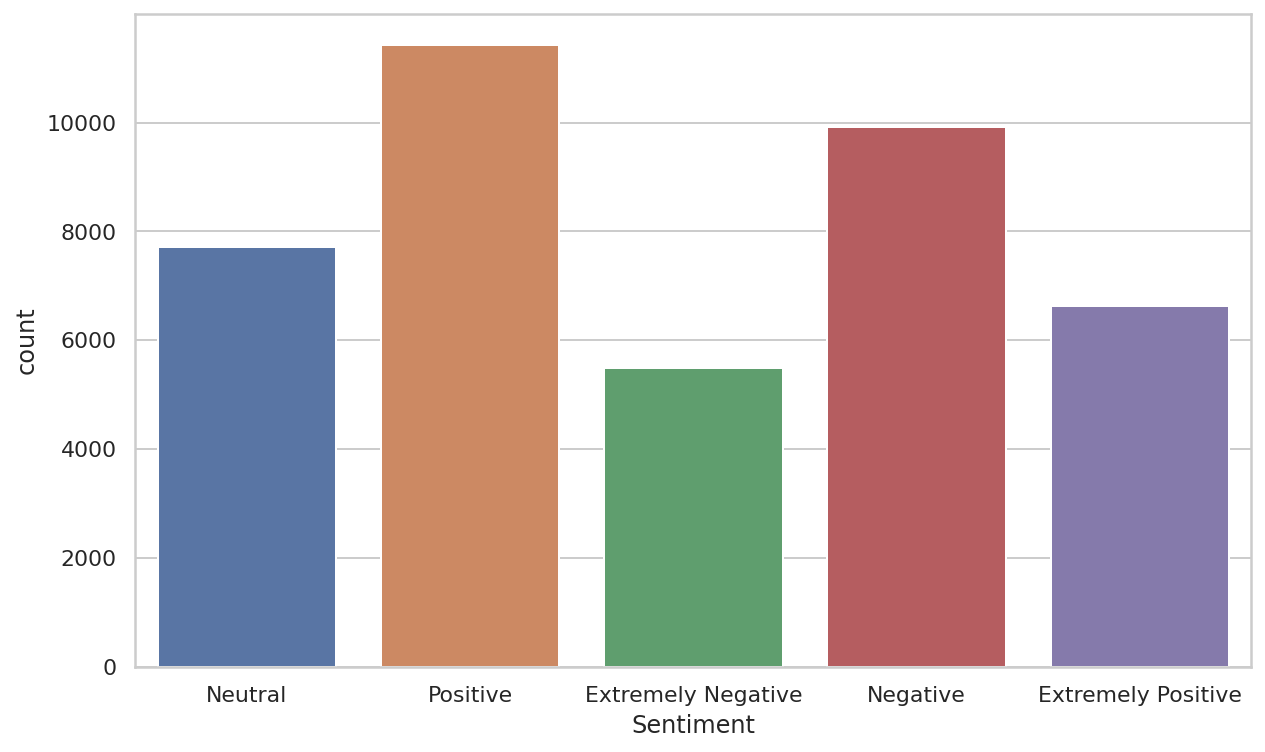

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(train_df['Sentiment'])

## Encode our target labels

In [ ]:
le=LabelEncoder()
train_df['Sentiment']=le.fit_transform(train_df['Sentiment'])
test_df['Sentiment']=le.transform(test_df['Sentiment'])

In [ ]:
train_df.dtypes

Location         object
TweetAt          object
OriginalTweet    object
Sentiment         int64
dtype: object

In [ ]:
le.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

In [ ]:
class_names=['Extremely Negative','Extremely Positive','Negative','Neutral','Positive']

Here, 0 - Extremely Negative, 1 - Extremely Positive, 2 - Negative, 3 - Neutral, 4 - Positive

# **BERT model**

### **Data Preprocessing**

### Let's tokenize the text to convert from raw text to numbers.

In [ ]:
pre_trained_BERTmodel='bert-base-uncased'

### Let's load a pre-trained BERT TokenizerFast:

In [ ]:
BERT_tokenizer=BertTokenizerFast.from_pretrained(pre_trained_BERTmodel)

### Let's check a text sample to understand BERT tokenization:

In [ ]:
text= "I was on cloud nine, when I got a new project."

#Convert text to tokens & token_ids
tokens=BERT_tokenizer.tokenize(text)
token_ids=BERT_tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence : {text}')
print(f'Tokens :{tokens}')
print(f'Token IDs : {token_ids}')

Sentence : I was on cloud nine, when I got a new project.
Tokens :['i', 'was', 'on', 'cloud', 'nine', ',', 'when', 'i', 'got', 'a', 'new', 'project', '.']
Token IDs : [1045, 2001, 2006, 6112, 3157, 1010, 2043, 1045, 2288, 1037, 2047, 2622, 1012]


### Add Special tokens

BERT expects special tokens for each sentence,          
[SEP] - marker at the end of each sentence             
[CLS] - marker at the start of each sentence.            
[PAD] - marker for padding sentence to a specific length

In [ ]:
encoding=BERT_tokenizer.encode_plus(
    text,
    max_length=32,
    add_special_tokens=True,   # 'Add [SEP] & [CLS]'
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,  # Reurns array of 0's & 1's to distinguish padded tokens from real tokens.
    return_token_type_ids=False,
    return_tensors='pt'         # Returns pytorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Encoding contains input_ids & attention masks of same length 32 for each sentence.

In [ ]:
# Check input_ids
print('Maximum length of input_ids for each sentence : {}'.format(len(encoding['input_ids'][0])))
encoding['input_ids'][0]

Maximum length of input_ids for each sentence : 32


tensor([ 101, 1045, 2001, 2006, 6112, 3157, 1010, 2043, 1045, 2288, 1037, 2047,
        2622, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In above tensor,        
0 - Padded index (post -padding)   
102 - [SEP] Special token    
101 - [CLS] Special token

In [ ]:
#check attention mask
print(f"Maximum length of attention mask for each sentence : {len(encoding['attention_mask'][0])}")
encoding['attention_mask'][0]

Maximum length of attention mask for each sentence : 32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Let's have a look at the special tokens

In [ ]:
special_tokens=BERT_tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
special_tokens

['[CLS]',
 'i',
 'was',
 'on',
 'cloud',
 'nine',
 ',',
 'when',
 'i',
 'got',
 'a',
 'new',
 'project',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### **Choosing Sequence length for our dataset**

#### Let's store the token length of each tweet

In [ ]:
token_lens=[]
for tweet in train_df.OriginalTweet:
  tokens_tweet=BERT_tokenizer.encode(tweet,max_length=150,truncation=True)
  token_lens.append(len(tokens_tweet))

Text(0.5, 0, 'Token count')

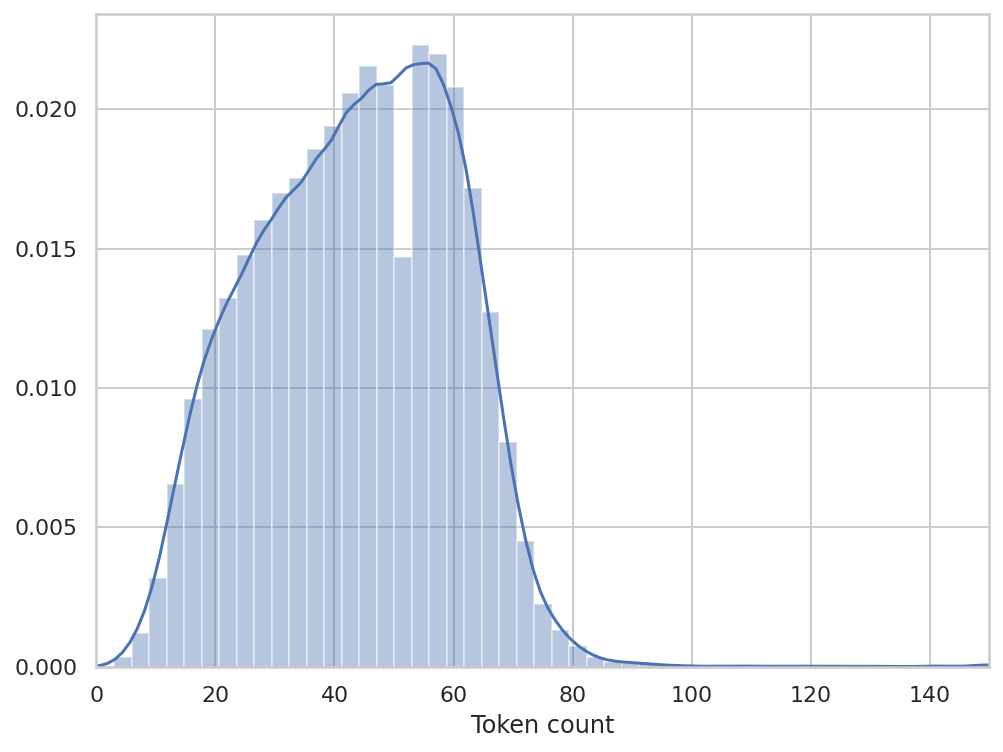

In [ ]:
#Plot the tokens
plt.figure(figsize=(8,6))
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

It appears that the length of most tokens lies between 0 & 100. On safer side, we are taking maximum sequence length of 120.

## Create a Pytorch Dataset

Pytorch dataset is of map-style i.e., it implements **getitem & len** protocols, & represents a map from indices/keys to datasamples.

In [ ]:
class tweets_Dataset(Dataset):

  def __init__(self,tweets,targets,tokenizer,max_length):
    self.tweets=tweets
    self.targets=targets
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self,item):
    tweet = str(self.tweets[item])
    targets = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        tweet,
        max_length=Max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'tweets_text':tweet,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(targets,dtype=torch.long)
    }

### **Let's split the train data**

In [ ]:
df_train,df_val=train_test_split(train_df,test_size=0.15 ,random_state=123)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape} ')
print(f'Testing dataset : {test_df.shape}') 
print(f'Validation dataset : {df_val.shape}')

Print the shape of datasets...
Training dataset : (34983, 4) 
Testing dataset : (3798, 4)
Validation dataset : (6174, 4)


Create a function for **Data loader**

In [ ]:
batch_size=8
Max_length= 120
def data_loader(df,tokenizer, max_length, batch):
  ds=tweets_Dataset(
      tweets=df.OriginalTweet.to_numpy(),
      targets=df.Sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train, BERT_tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(test_df, BERT_tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_val, BERT_tokenizer,Max_length,batch_size)

#### Let's have a look at an example batch from **training DataLoader**

In [ ]:
BERT_data=next(iter(train_DataLoader))
BERT_data.keys()

dict_keys(['tweets_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print('Shape of the BERT_data keys...')
print(f"Input_ids : {BERT_data['input_ids'].shape}")
print(f"Attention_mask : {BERT_data['attention_mask'].shape}")
print(f"targets : {BERT_data['targets'].shape}")

Shape of the BERT_data keys...
Input_ids : torch.Size([8, 120])
Attention_mask : torch.Size([8, 120])
targets : torch.Size([8])


Now move the batch training data to the GPU

In [ ]:
input_ids = BERT_data['input_ids'].to(device)
attention_mask = BERT_data['attention_mask'].to(device)
targets=BERT_data['targets'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 120])
torch.Size([8, 120])


## Now build a Sentiment Classifier

[](http://)Let's load basic BERT model

In [ ]:
BERT_model = BertModel.from_pretrained(pre_trained_BERTmodel)
BERT_model=BERT_model.to(device)

In [ ]:
n_classes=5

Now create a classifier that uses BERT model

In [ ]:
class BERT_SentimentClassifier(nn.Module):
   def __init__(self, n_classes):
     super(BERT_SentimentClassifier, self).__init__()
     self.bert = BertModel.from_pretrained(pre_trained_BERTmodel)
     self.drop = nn.Dropout(p=0.35)
     self.hidden=nn.Linear(self.bert.config.hidden_size,128)
     self.out = nn.Linear(128, n_classes)
     #self.softmax=nn.Softmax(dim=1)
   def forward(self, input_ids, attention_mask):
     _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask
    )
     output = self.drop(pooled_output)
     output=self.hidden(output)
     output=self.out(output)
     #output=self.softmax(output)
     return output

The **pooled_output** is the summary of the tweet.
We are using a **dropout** layer for some regularization and 2 **fully-connected** layers for our output.

Let’s create an instance and move it to the GPU

In [ ]:
BERT_model = BERT_SentimentClassifier(len(class_names))
BERT_model=BERT_model.to(device)

Apply softmax function to the classifier output:

In [ ]:
F.softmax(BERT_model(input_ids,attention_mask), dim=1).to(device)

tensor([[0.1820, 0.2898, 0.1474, 0.1466, 0.2342],
        [0.1876, 0.3182, 0.1256, 0.1619, 0.2067],
        [0.1363, 0.2759, 0.1716, 0.1366, 0.2796],
        [0.2083, 0.2374, 0.1825, 0.1174, 0.2545],
        [0.1408, 0.2771, 0.1493, 0.1558, 0.2769],
        [0.1705, 0.2222, 0.1777, 0.1793, 0.2503],
        [0.1351, 0.2870, 0.1662, 0.1803, 0.2314],
        [0.1459, 0.2556, 0.1589, 0.1195, 0.3201]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
BERT_model

BERT_SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

Let's train our BERT Sentiment classifier

We will use **AdamW** optimizer for correcting weight decay. We will also use, **linear scheduler** with no warm up steps:

In [ ]:
epochs=5
optimizer=AdamW(BERT_model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

Now write a helper function to train our model:

In [ ]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    #Feed data to BERT model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_observations, np.mean(losses)

Similarly, write a function to evaluate our model:

In [ ]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      # Feed data to BERT model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_observations, np.mean(losses)

Using above helper functions, write our training loop & store training history:

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_acc, train_loss = train(
    BERT_model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    BERT_model,
    valid_DataLoader,
    device,
    loss_fn,
    len(df_val)
  )
  print(f'Validation  loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(BERT_model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.748812172237316 accuracy 0.7109453162964868
Validation  loss 0.47807285251877624 accuracy 0.8328474246841594

Epoch 2/5
----------
Train loss 0.42703209632891365 accuracy 0.8651916645227682
Validation  loss 0.555474780803942 accuracy 0.8550372529964366

Epoch 3/5
----------
Train loss 0.32472420108093347 accuracy 0.912757625132207
Validation  loss 0.5627963538925523 accuracy 0.862325882734046

Epoch 4/5
----------
Train loss 0.23945950140458122 accuracy 0.9412571820598576
Validation  loss 0.6466113979107256 accuracy 0.873015873015873

Epoch 5/5
----------
Train loss 0.17267165586788993 accuracy 0.9604665123059772
Validation  loss 0.6461382596251384 accuracy 0.8798185941043084

CPU times: user 4h 2min 3s, sys: 16min 56s, total: 4h 18min 59s
Wall time: 4h 23min 39s


Let's look at **training vs validation accuracy**:

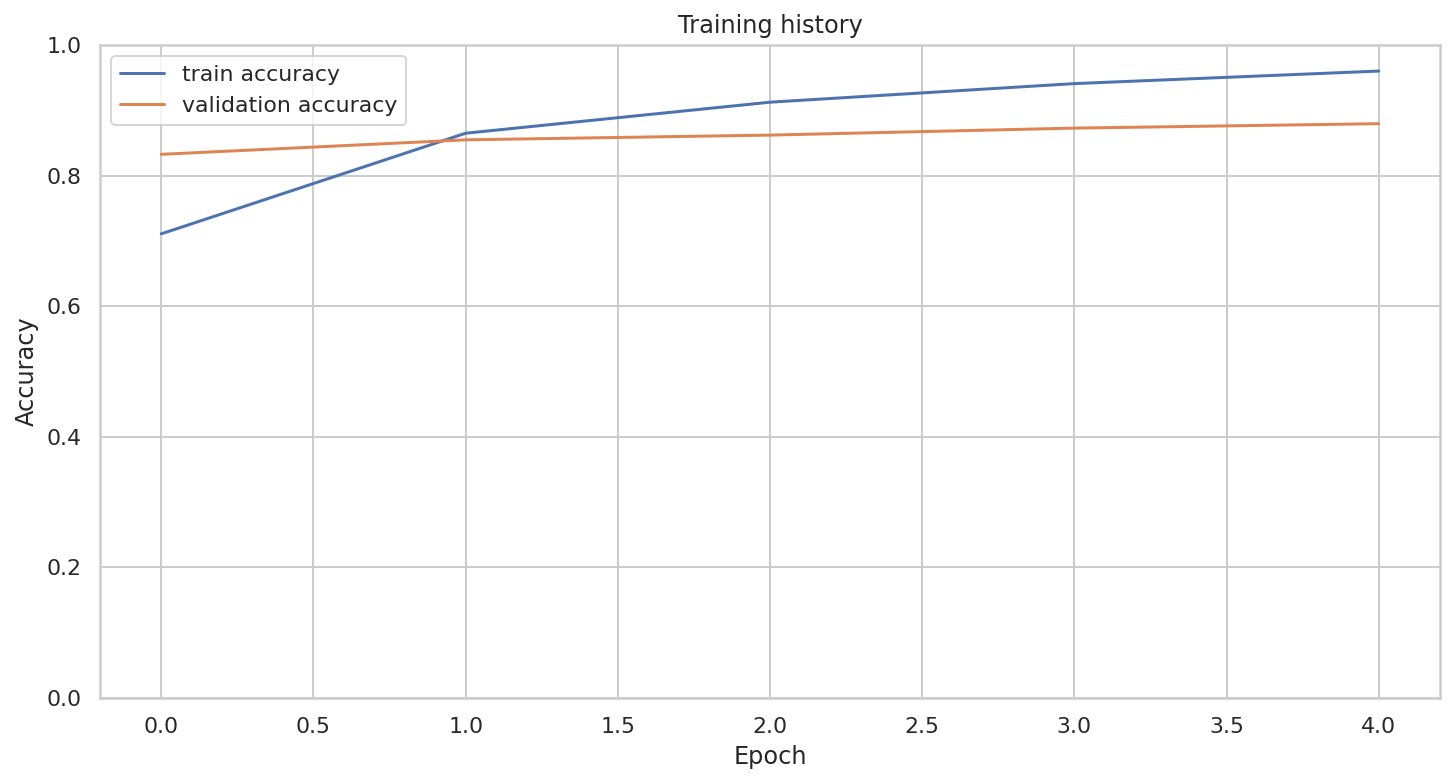

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

**Model Evaluation**

Let's see how good our model on unseen data.

In [ ]:
test_acc, _ = eval_model(
  BERT_model,
  test_DataLoader,
  device,
  loss_fn,
  len(test_df)
)

In [ ]:
test_acc.item()

0.8478146392838335

Now we will write a function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  tweets = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["tweets_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      tweets.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets, predictions, prediction_probs, real_values

In [ ]:
tweets, y_pred, y_pred_probs, y_test = get_predictions(
  BERT_model,
  test_DataLoader
)

Let's have a look at the classification report:

In [ ]:
class_report=classification_report(y_test, y_pred, target_names=class_names)
print(class_report)

                    precision    recall  f1-score   support

Extremely Negative       0.85      0.89      0.87       592
Extremely Positive       0.89      0.87      0.88       599
          Negative       0.84      0.83      0.83      1041
           Neutral       0.84      0.86      0.85       619
          Positive       0.83      0.82      0.83       947

          accuracy                           0.85      3798
         macro avg       0.85      0.85      0.85      3798
      weighted avg       0.85      0.85      0.85      3798



Now will plot confusion matrix:

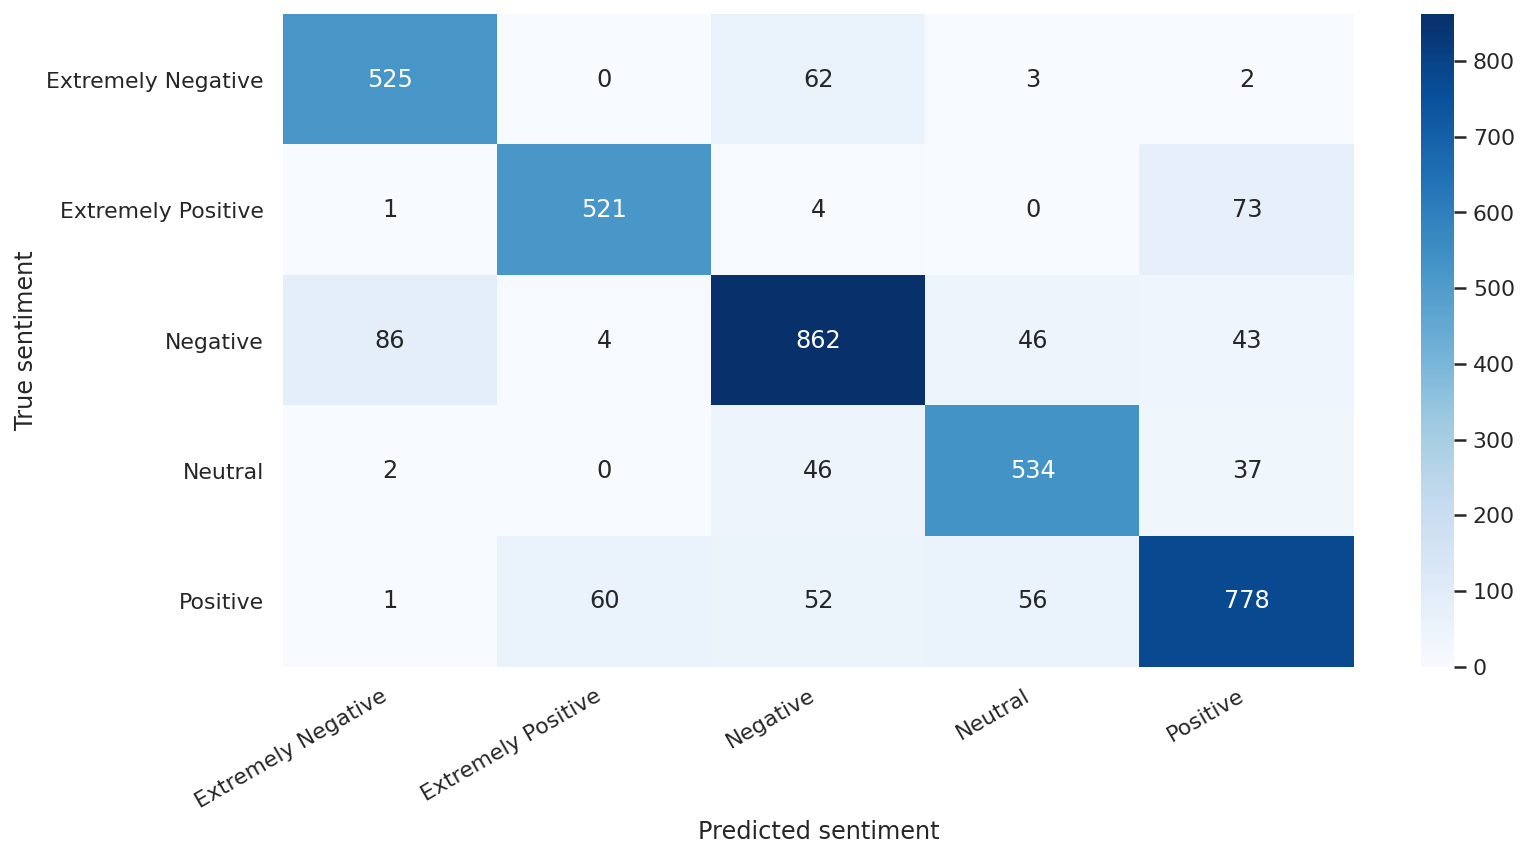

In [ ]:
plt.figure(figsize=(12,6))
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# Binarize the targets & predictions to plot PR & ROC curves
y_test= label_binarize(y_test, classes=[*range(n_classes)])
y_pred = label_binarize(y_pred, classes=[*range(n_classes)])

Plot PR (Precesion-Recall) curve:

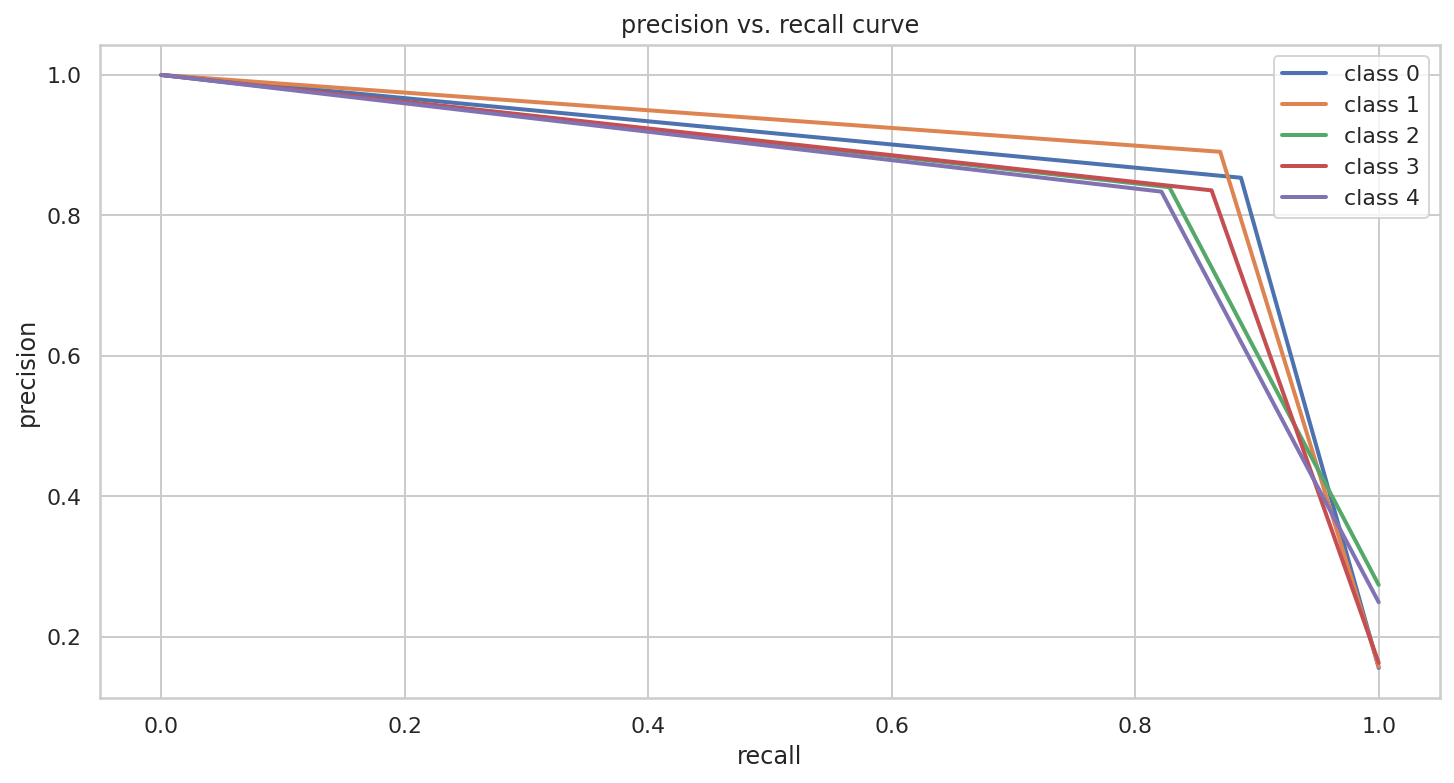

In [ ]:
# plot model precision-recall curve
precision = dict()
recall = dict()
plt.figure(figsize=(12,6))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

**ROC (Receiver operating characterstic) curve**:

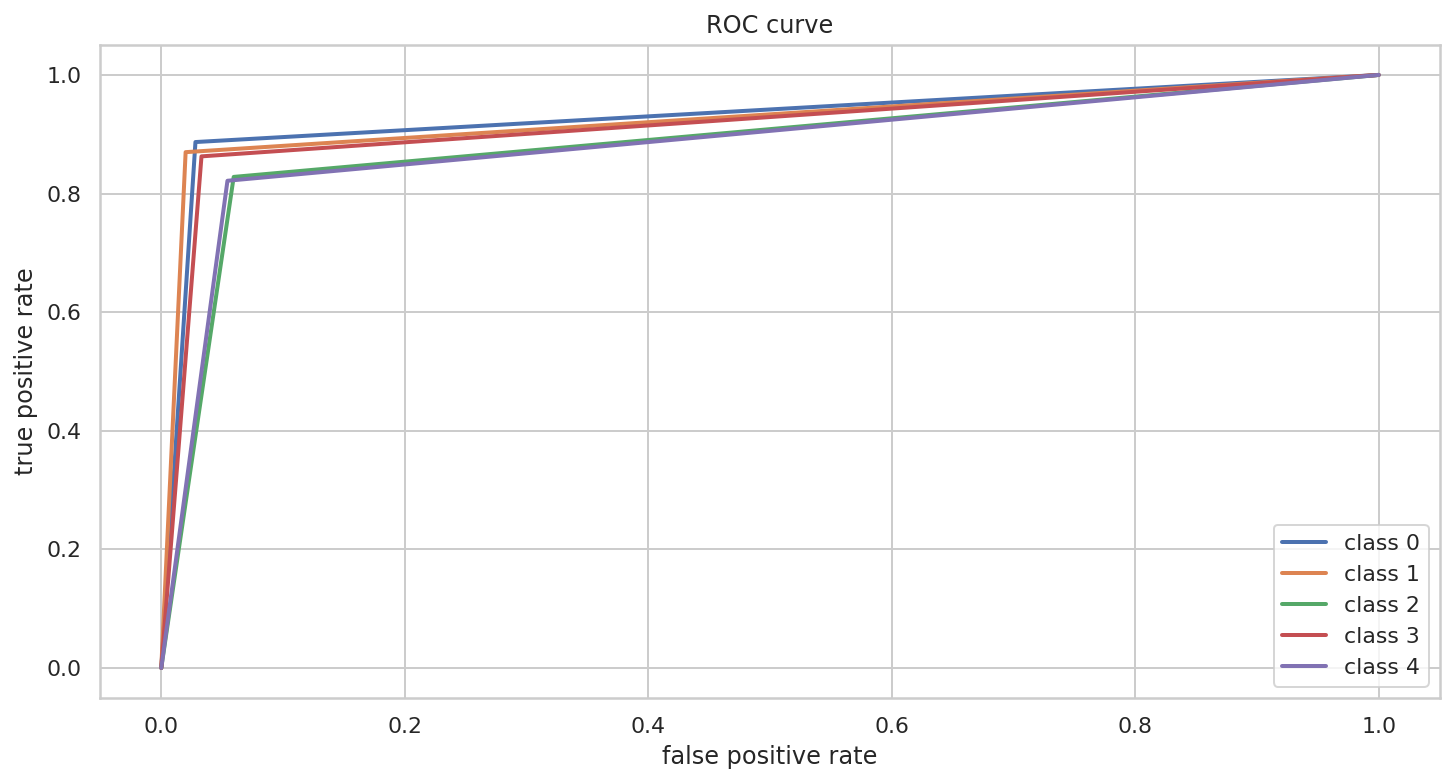

In [ ]:
# plot roc curve
fpr = dict()
tpr = dict()

plt.figure(figsize=(12,6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()